# Feature selection (simple)

Download the fruits data [here](https://drive.google.com/file/d/1M8tiAWDZclABJN1Meq9oEHCLJTNyHdpP/view?usp=share_link)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [13]:
np.random.seed(1)

# Load dataset
data = pd.read_csv("/content/fruits_data_ext.csv")
X, y =  data.iloc[:, 4:8], data.iloc[:, 1]

print (X.shape, y.shape)

(177, 4) (177,)


In [14]:
## Add some noisy data to degrade features
random_columns = np.random.permutation(24)
random_features = np.random.RandomState(1000).uniform(0, 0.5, size=(X.shape[0], 20))
X = np.hstack((X, random_features))
X = X[:, random_columns]

print (X.shape, y.shape)
print ('', random_columns, '\n', np.arange(24))

(177, 24) (177,)
 [13 18  3 14 20 17 10  4  2 19  6  7 21  1 16  0 15 23 22  9  8 12 11  5] 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [15]:
# Normalize data to 0-1
X = MinMaxScaler().fit_transform(X)

# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print ("\n", random_columns, "\n", np.arange(24))

(141, 24) (36, 24) (141,) (36,)

 [13 18  3 14 20 17 10  4  2 19  6  7 21  1 16  0 15 23 22  9  8 12 11  5] 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


## Classification using SVC

In [16]:
# Train a classifier using SVC on train data
svm = SVC(kernel='linear')

svm.fit(X_train, y_train)

SVC(kernel='linear')

Acc base: 0.722


<Axes: >

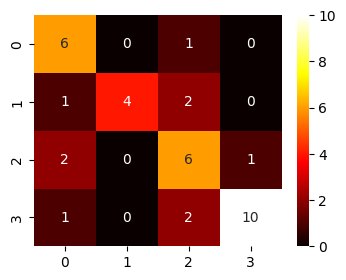

In [17]:
# Take predictions and compute some metrics (acc and CM)
predictions = svm.predict(X_test)
acc = accuracy_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)

print ("Acc base: {0:0.3f}".format(acc))
_, ax = plt.subplots(figsize=(4,3))
sns.heatmap(cm, annot=True, cmap='hot', ax=ax)

## Use Recursive Feature Elimination

### RFE -> [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)


In [ ]:
from sklearn.feature_selection import RFE

# Create a new SVC classifier
clf =

# Compute RFE
rfe = RFE( estimator = _ , n_features_to_select = _ )

best_features = rfe.fit( _ , _ )


In [ ]:
# See results
print("Num Features: %d" % best_features.n_features_)
print("Selected Features: %s" % best_features.ranking_)
print("                 : %s" % np.arange(22))

In [ ]:
list_best = np.where(best_features.ranking_ == 1)[0].tolist()
print (list_best)

In [ ]:
# Select best features
best_train = _
best_test  = _

print(best_train.shape, best_test.shape)

In [ ]:
# Retrain classifier on best features and make predictions


In [ ]:
# Compute metrics
acc_best =
cm_best  =

print("For Recursive feature elimination")



## Use univariate selection to determine best features


### SelectKBest -> [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)

Metrics: [F_classif (ANOVA)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif), [Chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2), [mutual_information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2 #ANOVA

skb = SelectKBest( _ , k = _ )
skb.fit( _ , _ )

best_train = _
best_test = _

print (best_train.shape)

(112, 2)


In [ ]:
print("Num Features: %d" % best_train.shape[0])
print("Selected Features: %s" % np.array(skb.get_support(),dtype=int).tolist())
print("                 : %s" % np.arange(22))

In [ ]:
# Retrain classifier on best features and make predictions



In [ ]:
# Compute metrics
acc_best =
cm_best  =

print("For Recursive feature elimination")



### SelectPercentile -> [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile)

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif, chi2 #ANOVA

spc = SelectPercentile( _ , percentile = _ )
spc.fit( _ , _ )

best_train =
best_test =

print (best_train.shape)

In [ ]:
print("Num Features: %d" % best_train.shape[0])
print("Selected Features: %s" % _ )
print("                 : %s" % np.arange(22))

In [ ]:
# Retrain classifier on best features and make predictions



In [ ]:
# Compute metrics
acc_best =
cm_best  =

print("For Recursive feature elimination")



## Use Metatransformer to determine best features

### SelectFromModel -> [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel)

In [ ]:
from sklearn.feature_selection import SelectFromModel

# Create a new SVC classifier
clf = _

# Compute metatransformer
sfm = SelectFromModel(estimator = clf)

best_features = sfm.fit(X_train, y_train)

In [ ]:
# Transform best features
best_train = _
best_test  = _

print(best_train.shape, best_test.shape)

In [ ]:
print("Num Features: %d" % sfm.n_features_in_)
print("Selected Features: %s" % _ )
print("                 : %s" % np.arange(22))

In [ ]:
# Retrain classifier on best features and make predictions



In [ ]:
# Compute metrics
acc_best =
cm_best  =

print("For Recursive feature elimination")

